# Set Up the Environment

### Importing Libraries

In [ ]:

%pip install torchmetrics
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
import torchvision
from torchvision import transforms
from torchmetrics.image import StructuralSimilarityIndexMeasure
from transformers import AutoModelForDepthEstimation
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
import time
import PIL
from PIL import Image
import requests
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

### Mount Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Needed Classes & Functions

### Class for Depth Model

In [ ]:
class DepthModel(nn.Module):
    """
    Wrapper class for the Depth-Anything model.
    """
    def __init__(self, mod):
        super().__init__()
        self.model = mod
        self.eval()

    def forward(self, x):
        original_size = x.shape[2:]
        outputs = self.model(x)
        predicted_depth = outputs.predicted_depth
        # The shape is (batch, channel, height, width), so unpack accordingly
        # print(predicted_depth.shape) # Keep for debugging if needed

        # Ensure the tensor has 4 dimensions
        if predicted_depth.dim() == 3:
             predicted_depth = predicted_depth.unsqueeze(1) # Add a batch dimension if it's missing

        b, c, h, w = predicted_depth.shape
        predicted_depth_flat = predicted_depth.view(b, -1)
        # Find the max value for each image in the batch
        max_vals = predicted_depth_flat.max(dim=1, keepdim=True)[0]
        # Avoid division by zero
        max_vals[max_vals == 0] = 1.0
        # Normalize the teacher's depth map to [0, 1]
        predicted_depth_normalized = predicted_depth_flat / max_vals
        predicted_depth_normalized = predicted_depth_normalized.view(b, c, h, w) # Reshape back to original dimensions
        predicted_depth_normalized = F.interpolate(predicted_depth_normalized.unsqueeze(1), size=original_size, mode='bilinear', align_corners=False)
        return predicted_depth_normalized

### Class for Student Model

In [ ]:
class StudentModel(nn.Module):
    """
    Student model with MobileNetV3 encoder and a custom decoder.
    Designed for real-time inference on edge devices.
    Corrected skip connections and decoder logic.
    """
    def __init__(self, output_channels=1):
        super(StudentModel, self).__init__()
        # Load MobileNetV3 Large features as the encoder
        self.encoder = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT).features

        # Freeze encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Decoder blocks, ensuring correct input channels after concatenation
        # The input channels for decoder_block1 are 960 (from encoder final) + 112 (from s32)
        self.decoder_block1 = nn.Sequential(
            nn.Conv2d(960 + 112, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        # Input channels for decoder_block2 are 512 (from decoder_block1) + 80 (from s16)
        self.decoder_block2 = nn.Sequential(
            nn.Conv2d(512 + 80, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        # Input channels for decoder_block3 are 256 (from decoder_block2) + 40 (from s8)
        self.decoder_block3 = nn.Sequential(
            nn.Conv2d(256 + 40, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        # Input channels for decoder_block4 are 128 (from decoder_block3) + 24 (from s4)
        self.decoder_block4 = nn.Sequential(
            nn.Conv2d(128 + 24, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

        self.final_conv = nn.Sequential(
            nn.Conv2d(64, output_channels, kernel_size=1), 
            nn.Sigmoid())

    def forward(self, x):
        original_size = x.shape[2:]
        skip_features = {}
        # Iterate through encoder layers to get skip connections
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            if i == 2:  # s4 (H/4, W/4 resolution)
                skip_features['s4'] = x
            elif i == 4:  # s8 (H/8, W/8 resolution)
                skip_features['s8'] = x
            elif i == 7:  # s16 (H/16, W/16 resolution)
                skip_features['s16'] = x
            elif i == 11:  # s32 (Currently H/16, W/16 resolution from your logs)
                skip_features['s32'] = x

        # Problem Fix: Ensure s32 matches the spatial dimension of x (encoder final output)
        # If s32 is 24x24 and x is 12x12, downsample s32.
        # This checks if the height and width of s32 are different from x.
        if skip_features['s32'].shape[2:] != x.shape[2:]:
            skip_features['s32'] = F.interpolate(skip_features['s32'], size=x.shape[2:], mode='bilinear', align_corners=False)

        # Decoder path
        # Concatenate final encoder output (x) with the adjusted s32 skip connection
        x = torch.cat([x, skip_features['s32']], dim=1)
        x = self.decoder_block1(x)

        # Concatenate with s16
        x = torch.cat([x, skip_features['s16']], dim=1)
        x = self.decoder_block2(x)

        # Concatenate with s8
        x = torch.cat([x, skip_features['s8']], dim=1)
        x = self.decoder_block3(x)

        # Concatenate with s4
        x = torch.cat([x, skip_features['s4']], dim=1)
        x = self.decoder_block4(x)

        x = self.final_conv(x)
        # Upsample to the original input size for the final depth map
        x = F.interpolate(x, size=original_size, mode='bilinear', align_corners=False)
        return x

### Class for Dataset Loading & Preprocessing

In [16]:
class UnlabeledImageDataset(Dataset):
    """
    Custom dataset for unlabeled images.
    """
    def __init__(self, root_dir, transform=None, resize_size=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'JPG'))]
        self.resize_size = resize_size
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.resize_size:
            image = image.resize(self.resize_size)

        if self.transform:
            image = self.transform(image)


        return image

### Distillation Loss

In [6]:
class DepthCombinedDistillationLoss(nn.Module):
    """
    Custom loss function for depth distillation.
    Using Pixel wise MSE Loss, SSIM, Gradient MAE Loss, and Scale-Invariant MSE Loss.
    """
    def __init__(self, lambda_depth=1.0, lambda_si=1.0, lambda_grad=1.0, lambda_ssim=1.0, lambda_smooth=0.2, window_size=11):
        super().__init__()
        self.lambda_depth = lambda_depth   # Weight for depth map MSE loss
        self.lambda_si = lambda_si         # Weight for Scale-Invariant MSE loss
        self.lambda_grad = lambda_grad     # Weight for Gradient loss
        self.lambda_ssim = lambda_ssim     # Weight for SSIM loss
        self.lambda_smooth = lambda_smooth # Weight for smoothness regularizer

        self.mse_depth_loss = nn.MSELoss()  # Mean Squared Error for depth maps
        self.l1_loss = nn.L1Loss()          # L1 Loss for gradients

        # Initialize the SSIM calculation from torchmetrics
        if self.lambda_ssim > 0:
            self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0, kernel_size=window_size)

    def forward(self, student_outputs, teacher_outputs):
        student_depth = student_outputs
        teacher_depth = teacher_outputs

        # Ensure tensors have a batch dimension
        if student_depth.dim() == 3:
            student_depth = student_depth.unsqueeze(0)
        if teacher_depth.dim() == 3:
            teacher_depth = teacher_depth.unsqueeze(0)

        # Ensure tensors have a channel dimension for SSIM
        if student_depth.dim() == 3: # Assuming (Batch, Height, Width)
            student_depth = student_depth.unsqueeze(1) # Becomes (Batch, Channel, Height, Width)
        if teacher_depth.dim() == 3: # Assuming (Batch, Height, Width)
            teacher_depth = teacher_depth.unsqueeze(1) # Becomes (Batch, Channel, Height, Width)


        total_loss = torch.tensor(0.0, device=student_depth.device)

        # 1. MSE Depth Loss
        if self.lambda_depth > 0:
            loss_depth = self.mse_depth_loss(student_depth, teacher_depth)
            total_loss += self.lambda_depth * loss_depth

        # 2. Scale-Invariant MSE Loss
        if self.lambda_si > 0:
            diff = student_depth - teacher_depth
            loss_si = torch.mean(diff**2) - torch.mean(diff)**2
            total_loss += self.lambda_si * loss_si

        # 3. Gradient Loss (using L1 on gradients)
        if self.lambda_grad > 0:
            student_grad_x = torch.abs(student_depth[:, :, :, :-1] - student_depth[:, :, :, 1:])
            student_grad_y = torch.abs(student_depth[:, :, :-1, :] - student_depth[:, :, 1:, :])
            teacher_grad_x = torch.abs(teacher_depth[:, :, :, :-1] - teacher_depth[:, :, :, 1:])
            teacher_grad_y = torch.abs(teacher_depth[:, :, :-1, :] - teacher_depth[:, :, 1:, :])

            loss_grad = self.l1_loss(student_grad_x, teacher_grad_x) + self.l1_loss(student_grad_y, teacher_grad_y)
            total_loss += self.lambda_grad * loss_grad

        # 4.Smoothness Loss (Regularizer)
        if self.lambda_smooth > 0:
            # Penalizes the L1 norm of the student's depth gradients
            loss_smooth = torch.mean(student_grad_x) + torch.mean(student_grad_y)
            total_loss += self.lambda_smooth * loss_smooth

        # 5. SSIM Loss
        if self.lambda_ssim > 0:
            # Move ssim module to the same device as the tensors
            self.ssim.to(student_depth.device)

            # The torchmetrics SSIM implementation returns a value between -1 and 1.
            # A value of 1 indicates perfect similarity.
            # To use it as a loss, we subtract it from 1.
            d_ssim = self.ssim(student_depth, teacher_depth)
            loss_ssim = (1 - d_ssim) / 2 # Normalize to be between 0 and 1
            total_loss += self.lambda_ssim * loss_ssim

        return total_loss

### The Training Function

In [7]:
def train_knowledge_distillation(teacher, student, train_dataloader, val_dataloader, criterion, optimizer, epochs, device):
    """
    Train the student model using Response-Based knowledge distillation.
    """
    teacher.eval() # Teacher should always be in evaluation mode

    print(f"Starting Knowledge Distillation Training on {device}...")
    min_loss = float('inf')
    for epoch in range(epochs):
        student.train() # Student in training mode
        running_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        start_time = time.time()

        for images in progress_bar:
            images = images.to(device)
            optimizer.zero_grad()

            # Forward pass with Teacher model (no_grad as teacher is fixed)
            with torch.no_grad():
                teacher_outputs = teacher(images) # Returns depth map

            # Forward pass with Student model
            student_outputs = student(images) # Returns depth map

            # Calculate distillation loss
            loss = criterion(student_outputs, teacher_outputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        epoch_loss = running_loss / len(train_dataloader)
        current_lr = scheduler.get_last_lr()[0]
        end_time = time.time()
        print(f"End of Epoch {epoch+1},Time: {end_time - start_time:.2f}s, Current LR: {current_lr:.6f}, Average Loss: {epoch_loss:.4f}")
        scheduler.step()

        # Validation loop
        student.eval() # Student in evaluation mode for validation
        val_running_loss = 0.0
        with torch.no_grad():
            progress_bar_val = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")
            for val_images in progress_bar_val:
                val_images = val_images.to(device)
                teacher_outputs = teacher(val_images)
                student_outputs = student(val_images)
                val_loss = criterion(student_outputs, teacher_outputs)
                val_running_loss += val_loss.item()

        val_epoch_loss = val_running_loss / len(val_dataloader)
        print(f"Average Validation Loss: {val_epoch_loss:.4f}")

        if val_epoch_loss < min_loss:
            min_loss = val_epoch_loss
            print("Validation loss improved. Saving the model.")
            torch.save(student.state_dict(), f"/content/drive/MyDrive/best_student.pth")

    print("Knowledge Distillation Training Finished!")

# Training Process

### Define Parameters & Models

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load teacher model
teacher = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to(device)


teacher_model = DepthModel(teacher).to(device)

# student  model architecture
student_model = StudentModel().to(device)

######################################################
# Load the entire model object from the checkpoint
# student_model = torch.load('/content/drive/MyDrive/distillSkip1700.pth', weights_only=False).to(device)

###########################
# Initialize optimizer for the student model
# student_optimizer = optim.Adam(student_model.parameters(), lr=1e-4)
student_optimizer = optim.AdamW(student_model.parameters(), lr=1e-3, weight_decay=1e-3)

# Training parameters
num_epochs = 60
# scheduler = CosineAnnealingLR(student_optimizer, T_max=num_epochs, eta_min=1e-5ss)
scheduler = StepLR(student_optimizer, step_size=20, gamma=0.9)
# Distillation Loss
# Instantiate the custom loss function
distillation_criterion = DepthCombinedDistillationLoss(lambda_depth=0.5,  lambda_si=1.0, lambda_grad=1.0, lambda_ssim=1.0, window_size=11)

# transformations for input images (teacher and student will use the same)

input_size = (384, 384)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Specify the path to your unlabeled data in Google Drive
unlabeled_data_path = '/content/drive/MyDrive/images/'

# Create dataset and data loader
unlabeled_dataset = UnlabeledImageDataset(root_dir=unlabeled_data_path, transform=transform, resize_size=input_size)

dataset_size = len(unlabeled_dataset)
train_size = int(0.7 * dataset_size)
val_size = dataset_size - train_size
# Split the dataset
train_dataset, val_dataset = torch.utils.data.random_split(unlabeled_dataset, [train_size, val_size])
# Create separate dataloaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Using device: cuda
Found 152 images in /content/drive/MyDrive/images/
Training set size: 106
Validation set size: 46


Before Training

In [32]:
# Load train image
image_path = "/content/drive/MyDrive/images/image1.JPG"
train_image = cv2.imread(image_path)
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

train_input_tensor = eval_transform(Image.fromarray(train_image)).unsqueeze(0).to(device)
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_depth_before = student_model(input_tensor)
    student_depth_before_training = student_depth_before.squeeze().cpu().numpy()
    student_depth_before = student_model(train_input_tensor)
    student_depth_before_training_train_image = student_depth_before.squeeze().cpu().numpy()


### Freeze Student's Encoder

In [ ]:
# --- Verify which layers are trainable ---
total_param = 0
train_param = 0
for name, param in student_model.named_parameters():
    total_param += param.numel()
    if param.requires_grad:
        train_param += param.numel()
print(f"Total Parameters: {total_param}")
print(f"Trainable Parameters: {train_param}")


# print("----------------------------------------")
# for name, param in student_model.named_parameters():
#     param.requires_grad = False

# # Unfreeze parameters in the 'head' layer
# for name, param in student_model.decoder.named_parameters():
#     param.requires_grad = True

# # --- Verify which layers are trainable ---
# print("Trainable parameters in student_model:")
# for name, param in student_model.named_parameters():
#     if param.requires_grad:
#         print(f"  {name}")


All parameters in student_model:
  decoder_block1.0.weight
  decoder_block1.0.bias
  decoder_block2.0.weight
  decoder_block2.0.bias
  decoder_block3.0.weight
  decoder_block3.0.bias
  decoder_block4.0.weight
  decoder_block4.0.bias
  final_conv.weight
  final_conv.bias


### Run the Training

In [35]:
    # Run the training
train_knowledge_distillation(
    teacher=teacher_model,
    student=student_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=distillation_criterion,
    optimizer=student_optimizer,
    epochs=num_epochs,
    device=device
)

print("Training complete. Student model saved at specified checkpoints.")


Starting Knowledge Distillation Training on cuda...


Epoch 1/60: 100%|██████████| 11/11 [00:35<00:00,  3.22s/it]


End of Epoch 1,Time: 35.39s, Current LR: 0.001000, Average Loss: 19562.0441


Epoch 1/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 17042.9903
Validation loss improved. Saving the model.


Epoch 2/60: 100%|██████████| 11/11 [00:36<00:00,  3.35s/it]


End of Epoch 2,Time: 36.84s, Current LR: 0.001000, Average Loss: 10608.8859


Epoch 2/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Average Validation Loss: 11774.9647
Validation loss improved. Saving the model.


Epoch 3/60: 100%|██████████| 11/11 [00:36<00:00,  3.34s/it]


End of Epoch 3,Time: 36.69s, Current LR: 0.001000, Average Loss: 7884.2698


Epoch 3/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.12s/it]


Average Validation Loss: 11771.4748
Validation loss improved. Saving the model.


Epoch 4/60: 100%|██████████| 11/11 [00:35<00:00,  3.25s/it]


End of Epoch 4,Time: 35.77s, Current LR: 0.001000, Average Loss: 7194.3149


Epoch 4/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Average Validation Loss: 11925.8774


Epoch 5/60: 100%|██████████| 11/11 [00:34<00:00,  3.11s/it]


End of Epoch 5,Time: 34.24s, Current LR: 0.001000, Average Loss: 6273.8753


Epoch 5/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.11s/it]


Average Validation Loss: 10795.9707
Validation loss improved. Saving the model.


Epoch 6/60: 100%|██████████| 11/11 [00:36<00:00,  3.31s/it]


End of Epoch 6,Time: 36.39s, Current LR: 0.001000, Average Loss: 5916.5384


Epoch 6/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Average Validation Loss: 9979.8847
Validation loss improved. Saving the model.


Epoch 7/60: 100%|██████████| 11/11 [00:36<00:00,  3.32s/it]


End of Epoch 7,Time: 36.51s, Current LR: 0.001000, Average Loss: 5536.8548


Epoch 7/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Average Validation Loss: 10105.7258


Epoch 8/60: 100%|██████████| 11/11 [00:34<00:00,  3.14s/it]


End of Epoch 8,Time: 34.59s, Current LR: 0.001000, Average Loss: 5496.7678


Epoch 8/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Average Validation Loss: 10452.3062


Epoch 9/60: 100%|██████████| 11/11 [00:35<00:00,  3.26s/it]


End of Epoch 9,Time: 35.84s, Current LR: 0.001000, Average Loss: 4571.3192


Epoch 9/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Average Validation Loss: 11254.7131


Epoch 10/60: 100%|██████████| 11/11 [00:35<00:00,  3.27s/it]


End of Epoch 10,Time: 35.99s, Current LR: 0.001000, Average Loss: 4827.1177


Epoch 10/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 8691.2996
Validation loss improved. Saving the model.


Epoch 11/60: 100%|██████████| 11/11 [00:37<00:00,  3.44s/it]


End of Epoch 11,Time: 37.89s, Current LR: 0.001000, Average Loss: 4499.5422


Epoch 11/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 9755.1240


Epoch 12/60: 100%|██████████| 11/11 [00:36<00:00,  3.28s/it]


End of Epoch 12,Time: 36.12s, Current LR: 0.001000, Average Loss: 4438.7842


Epoch 12/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.12s/it]


Average Validation Loss: 9321.3115


Epoch 13/60: 100%|██████████| 11/11 [00:36<00:00,  3.28s/it]


End of Epoch 13,Time: 36.05s, Current LR: 0.001000, Average Loss: 4295.9076


Epoch 13/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 9071.9348


Epoch 14/60: 100%|██████████| 11/11 [00:37<00:00,  3.36s/it]


End of Epoch 14,Time: 37.01s, Current LR: 0.001000, Average Loss: 4143.5452


Epoch 14/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Average Validation Loss: 9699.6708


Epoch 15/60: 100%|██████████| 11/11 [00:35<00:00,  3.20s/it]


End of Epoch 15,Time: 35.24s, Current LR: 0.001000, Average Loss: 4032.8906


Epoch 15/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Average Validation Loss: 8877.9675


Epoch 16/60: 100%|██████████| 11/11 [00:36<00:00,  3.36s/it]


End of Epoch 16,Time: 36.97s, Current LR: 0.001000, Average Loss: 4063.3941


Epoch 16/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 9317.6543


Epoch 17/60: 100%|██████████| 11/11 [00:35<00:00,  3.20s/it]


End of Epoch 17,Time: 35.22s, Current LR: 0.001000, Average Loss: 3998.2627


Epoch 17/60 [Validation]: 100%|██████████| 12/12 [00:12<00:00,  1.08s/it]


Average Validation Loss: 9506.0474


Epoch 18/60: 100%|██████████| 11/11 [00:36<00:00,  3.28s/it]


End of Epoch 18,Time: 36.09s, Current LR: 0.001000, Average Loss: 3639.5027


Epoch 18/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Average Validation Loss: 8441.7991
Validation loss improved. Saving the model.


Epoch 19/60: 100%|██████████| 11/11 [00:37<00:00,  3.37s/it]


End of Epoch 19,Time: 37.04s, Current LR: 0.001000, Average Loss: 3578.8612


Epoch 19/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Average Validation Loss: 9148.4878


Epoch 20/60: 100%|██████████| 11/11 [00:34<00:00,  3.12s/it]


End of Epoch 20,Time: 34.30s, Current LR: 0.001000, Average Loss: 3524.0627


Epoch 20/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Average Validation Loss: 8448.8569


Epoch 21/60: 100%|██████████| 11/11 [00:36<00:00,  3.33s/it]


End of Epoch 21,Time: 36.61s, Current LR: 0.000900, Average Loss: 3239.3211


Epoch 21/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Average Validation Loss: 9167.8722


Epoch 22/60: 100%|██████████| 11/11 [00:36<00:00,  3.29s/it]


End of Epoch 22,Time: 36.23s, Current LR: 0.000900, Average Loss: 3111.6290


Epoch 22/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Average Validation Loss: 9768.8531


Epoch 23/60: 100%|██████████| 11/11 [00:36<00:00,  3.28s/it]


End of Epoch 23,Time: 36.03s, Current LR: 0.000900, Average Loss: 3231.1050


Epoch 23/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Average Validation Loss: 9097.5014


Epoch 24/60: 100%|██████████| 11/11 [00:35<00:00,  3.23s/it]


End of Epoch 24,Time: 35.51s, Current LR: 0.000900, Average Loss: 2815.8776


Epoch 24/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.12s/it]


Average Validation Loss: 9054.0840


Epoch 25/60: 100%|██████████| 11/11 [00:37<00:00,  3.43s/it]


End of Epoch 25,Time: 37.68s, Current LR: 0.000900, Average Loss: 2836.5592


Epoch 25/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 8143.1594
Validation loss improved. Saving the model.


Epoch 26/60: 100%|██████████| 11/11 [00:37<00:00,  3.44s/it]


End of Epoch 26,Time: 37.84s, Current LR: 0.000900, Average Loss: 3181.5777


Epoch 26/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Average Validation Loss: 9345.3417


Epoch 27/60: 100%|██████████| 11/11 [00:35<00:00,  3.19s/it]


End of Epoch 27,Time: 35.09s, Current LR: 0.000900, Average Loss: 3188.0184


Epoch 27/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Average Validation Loss: 9111.9947


Epoch 28/60: 100%|██████████| 11/11 [00:37<00:00,  3.38s/it]


End of Epoch 28,Time: 37.20s, Current LR: 0.000900, Average Loss: 3047.8206


Epoch 28/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Average Validation Loss: 8434.3373


Epoch 29/60: 100%|██████████| 11/11 [00:35<00:00,  3.25s/it]


End of Epoch 29,Time: 35.75s, Current LR: 0.000900, Average Loss: 2647.2547


Epoch 29/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Average Validation Loss: 8624.7829


Epoch 30/60: 100%|██████████| 11/11 [00:34<00:00,  3.10s/it]


End of Epoch 30,Time: 34.09s, Current LR: 0.000900, Average Loss: 2626.1066


Epoch 30/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Average Validation Loss: 11673.7103


Epoch 31/60: 100%|██████████| 11/11 [00:35<00:00,  3.20s/it]


End of Epoch 31,Time: 35.17s, Current LR: 0.000900, Average Loss: 2652.1535


Epoch 31/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Average Validation Loss: 8673.4162


Epoch 32/60: 100%|██████████| 11/11 [00:35<00:00,  3.27s/it]


End of Epoch 32,Time: 35.97s, Current LR: 0.000900, Average Loss: 2590.1348


Epoch 32/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 8227.9938


Epoch 33/60: 100%|██████████| 11/11 [00:35<00:00,  3.23s/it]


End of Epoch 33,Time: 35.53s, Current LR: 0.000900, Average Loss: 2855.9895


Epoch 33/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Average Validation Loss: 9334.5910


Epoch 34/60: 100%|██████████| 11/11 [00:34<00:00,  3.18s/it]


End of Epoch 34,Time: 35.00s, Current LR: 0.000900, Average Loss: 3229.0657


Epoch 34/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Average Validation Loss: 8695.4029


Epoch 35/60: 100%|██████████| 11/11 [00:36<00:00,  3.30s/it]


End of Epoch 35,Time: 36.34s, Current LR: 0.000900, Average Loss: 2933.7050


Epoch 35/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Average Validation Loss: 7917.6812
Validation loss improved. Saving the model.


Epoch 36/60: 100%|██████████| 11/11 [00:36<00:00,  3.32s/it]


End of Epoch 36,Time: 36.48s, Current LR: 0.000900, Average Loss: 2695.9147


Epoch 36/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.11s/it]


Average Validation Loss: 8020.8958


Epoch 37/60: 100%|██████████| 11/11 [00:34<00:00,  3.13s/it]


End of Epoch 37,Time: 34.39s, Current LR: 0.000900, Average Loss: 2501.1759


Epoch 37/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Average Validation Loss: 8890.9965


Epoch 38/60: 100%|██████████| 11/11 [00:35<00:00,  3.22s/it]


End of Epoch 38,Time: 35.47s, Current LR: 0.000900, Average Loss: 2489.3303


Epoch 38/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Average Validation Loss: 8672.9940


Epoch 39/60: 100%|██████████| 11/11 [00:35<00:00,  3.19s/it]


End of Epoch 39,Time: 35.08s, Current LR: 0.000900, Average Loss: 2469.5134


Epoch 39/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Average Validation Loss: 8220.1171


Epoch 40/60: 100%|██████████| 11/11 [00:36<00:00,  3.35s/it]


End of Epoch 40,Time: 36.90s, Current LR: 0.000900, Average Loss: 2494.4245


Epoch 40/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.10s/it]


Average Validation Loss: 7694.9876
Validation loss improved. Saving the model.


Epoch 41/60: 100%|██████████| 11/11 [00:35<00:00,  3.20s/it]


End of Epoch 41,Time: 35.23s, Current LR: 0.000810, Average Loss: 2339.6504


Epoch 41/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Average Validation Loss: 8154.4142


Epoch 42/60: 100%|██████████| 11/11 [00:36<00:00,  3.29s/it]


End of Epoch 42,Time: 36.16s, Current LR: 0.000810, Average Loss: 2299.5080


Epoch 42/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Average Validation Loss: 8105.4710


Epoch 43/60: 100%|██████████| 11/11 [00:36<00:00,  3.28s/it]


End of Epoch 43,Time: 36.07s, Current LR: 0.000810, Average Loss: 2296.7525


Epoch 43/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 7352.5162
Validation loss improved. Saving the model.


Epoch 44/60: 100%|██████████| 11/11 [00:37<00:00,  3.40s/it]


End of Epoch 44,Time: 37.40s, Current LR: 0.000810, Average Loss: 2169.0274


Epoch 44/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 7597.5649


Epoch 45/60: 100%|██████████| 11/11 [00:35<00:00,  3.19s/it]


End of Epoch 45,Time: 35.08s, Current LR: 0.000810, Average Loss: 2135.1927


Epoch 45/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.11s/it]


Average Validation Loss: 8618.7661


Epoch 46/60: 100%|██████████| 11/11 [00:35<00:00,  3.22s/it]


End of Epoch 46,Time: 35.42s, Current LR: 0.000810, Average Loss: 2202.7605


Epoch 46/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Average Validation Loss: 8366.4569


Epoch 47/60: 100%|██████████| 11/11 [00:37<00:00,  3.37s/it]


End of Epoch 47,Time: 37.02s, Current LR: 0.000810, Average Loss: 2334.6102


Epoch 47/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Average Validation Loss: 7808.8973


Epoch 48/60: 100%|██████████| 11/11 [00:34<00:00,  3.12s/it]


End of Epoch 48,Time: 34.27s, Current LR: 0.000810, Average Loss: 2184.1712


Epoch 48/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Average Validation Loss: 8364.2292


Epoch 49/60: 100%|██████████| 11/11 [00:36<00:00,  3.30s/it]


End of Epoch 49,Time: 36.27s, Current LR: 0.000810, Average Loss: 2257.6337


Epoch 49/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Average Validation Loss: 9135.8548


Epoch 50/60: 100%|██████████| 11/11 [00:36<00:00,  3.32s/it]


End of Epoch 50,Time: 36.47s, Current LR: 0.000810, Average Loss: 2181.0865


Epoch 50/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 8653.3931


Epoch 51/60: 100%|██████████| 11/11 [00:35<00:00,  3.26s/it]


End of Epoch 51,Time: 35.86s, Current LR: 0.000810, Average Loss: 2238.3877


Epoch 51/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 7872.6226


Epoch 52/60: 100%|██████████| 11/11 [00:35<00:00,  3.26s/it]


End of Epoch 52,Time: 35.91s, Current LR: 0.000810, Average Loss: 2276.7911


Epoch 52/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Average Validation Loss: 7989.2493


Epoch 53/60: 100%|██████████| 11/11 [00:34<00:00,  3.11s/it]


End of Epoch 53,Time: 34.27s, Current LR: 0.000810, Average Loss: 2162.1053


Epoch 53/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Average Validation Loss: 7608.8272


Epoch 54/60: 100%|██████████| 11/11 [00:36<00:00,  3.28s/it]


End of Epoch 54,Time: 36.06s, Current LR: 0.000810, Average Loss: 2184.9941


Epoch 54/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.11s/it]


Average Validation Loss: 8312.7741


Epoch 55/60: 100%|██████████| 11/11 [00:34<00:00,  3.18s/it]


End of Epoch 55,Time: 34.94s, Current LR: 0.000810, Average Loss: 2128.1988


Epoch 55/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 7998.2329


Epoch 56/60: 100%|██████████| 11/11 [00:36<00:00,  3.32s/it]


End of Epoch 56,Time: 36.52s, Current LR: 0.000810, Average Loss: 1976.4065


Epoch 56/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Average Validation Loss: 11206.4331


Epoch 57/60: 100%|██████████| 11/11 [00:35<00:00,  3.20s/it]


End of Epoch 57,Time: 35.17s, Current LR: 0.000810, Average Loss: 1958.2126


Epoch 57/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 7020.7757
Validation loss improved. Saving the model.


Epoch 58/60: 100%|██████████| 11/11 [00:37<00:00,  3.38s/it]


End of Epoch 58,Time: 37.19s, Current LR: 0.000810, Average Loss: 2025.4570


Epoch 58/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Average Validation Loss: 8053.1435


Epoch 59/60: 100%|██████████| 11/11 [00:34<00:00,  3.10s/it]


End of Epoch 59,Time: 34.10s, Current LR: 0.000810, Average Loss: 1853.3026


Epoch 59/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.11s/it]


Average Validation Loss: 7385.4426


Epoch 60/60: 100%|██████████| 11/11 [00:36<00:00,  3.28s/it]


End of Epoch 60,Time: 36.05s, Current LR: 0.000810, Average Loss: 1822.5201


Epoch 60/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]

Average Validation Loss: 11206.3968
Knowledge Distillation Training Finished!
Training complete. Student model saved at specified checkpoints.


In [ ]:
# Load the best student model from the checkpoint
best_student_model = StudentModel().to(device)
best_student_model.load_state_dict(torch.load('/content/drive/MyDrive/best_student.pth'))
best_student_model.eval()

# Unfreeze the decoder blocks and the final convolutional layer
for name, param in best_student_model.named_parameters():
    if 'decoder' in name or 'final_conv' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False # Ensure encoder remains frozen


# Verify which layers are trainable
print("Trainable parameters in best_student_model:")
for name, param in best_student_model.named_parameters():
    if param.requires_grad:
        print(f"  {name}")

print("All parameters in best_student_model:")
for name, param in best_student_model.named_parameters():
        print(f"  {name}: {param.requires_grad}")

# Evaluation

### On training

✅ Student model inference time: 9.50 ms


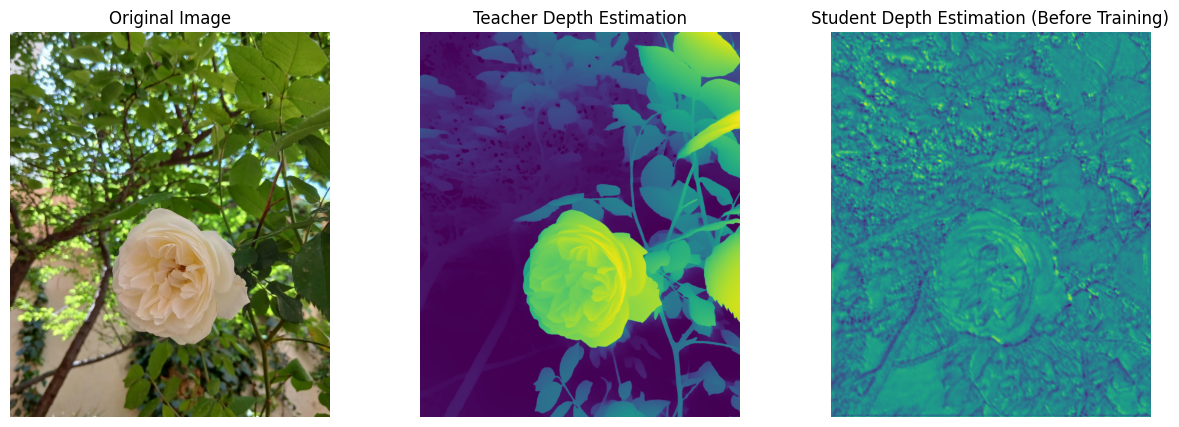

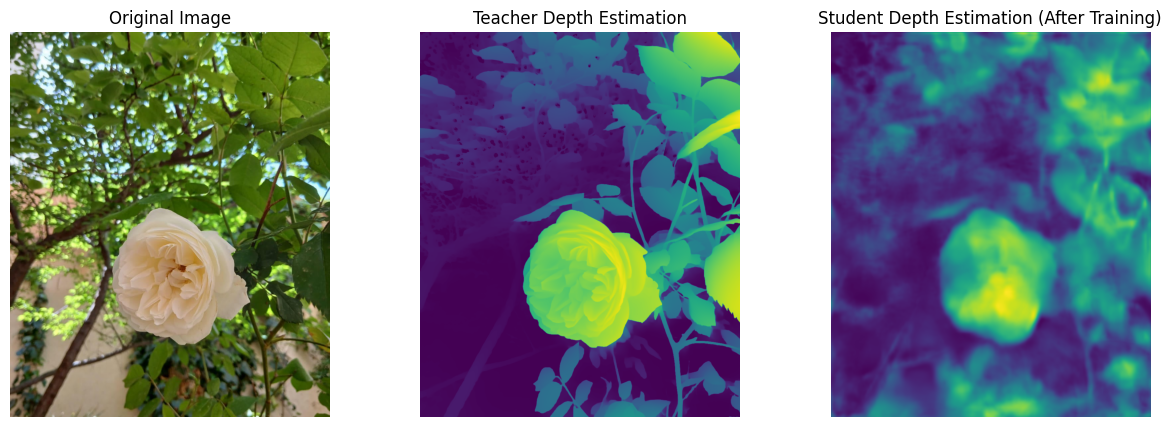

In [36]:
# Load image
image_path = "/content/drive/MyDrive/images/image1.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    start_time = time.time()
    student_output_after = student_model(input_tensor)
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000
    print(f"✅ Student model inference time: {inference_time_ms:.2f} ms")

    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

# loss = distillation_criterion(student_output_after_training, teacher_depth)
# print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training_train_image, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()



### On Testing

7413.517578125


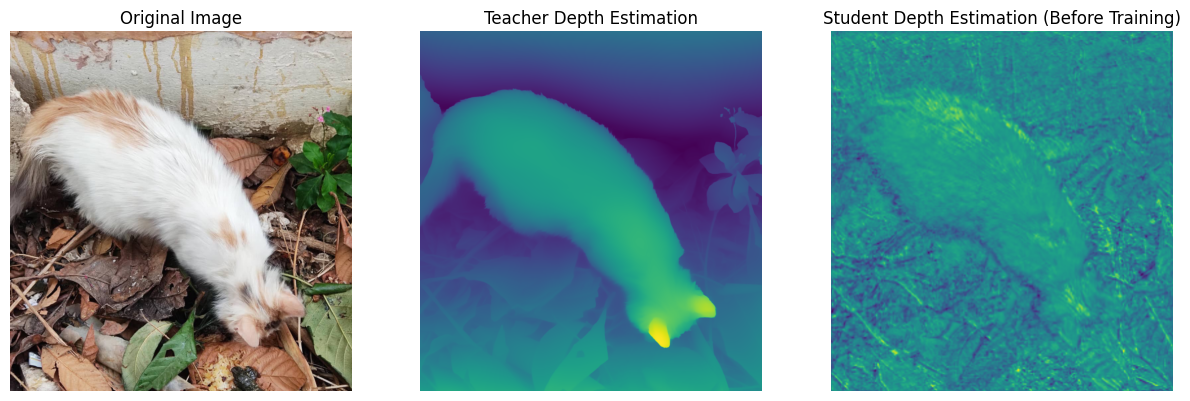

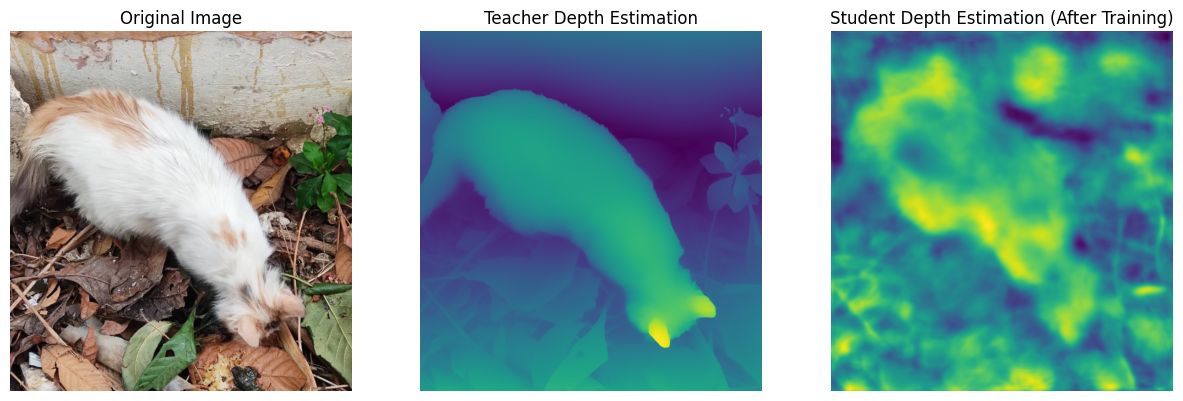

In [37]:
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance

loss = 0;
with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_output_after = student_model(input_tensor)
    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)
    loss = distillation_criterion(student_output_after, teacher_depth)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()

### Saving a CheckPoint

In [ ]:
torch.save(student_model, "/content/drive/MyDrive/distillSkipL2500.pth")

In [43]:
# student  model architecture
best_student_model = StudentModel().to(device)

######################################################
# Load the entire model object from the checkpoint
best_student_model = torch.load('/content/drive/MyDrive/best_student.pth', weights_only=True)




In [44]:
# Load image
image_path = "/content/drive/MyDrive/images/image1.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
# best_student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    start_time = time.time()
    student_output_after = best_student_model(input_tensor)
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000
    print(f"✅ Student model inference time: {inference_time_ms:.2f} ms")

    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

# loss = distillation_criterion(student_output_after_training, teacher_depth)
# print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training_train_image, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()



TypeError: 'collections.OrderedDict' object is not callable

In [ ]:
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
best_student_model.eval() # Use the DepthModel instance

loss = 0;
with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_output_after = best_student_model(input_tensor)
    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)
    loss = distillation_criterion(student_output_after, teacher_depth)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()